In [28]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [29]:
# import and review dataset
dataset_url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(dataset_url)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [30]:
# check for null values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [31]:
# define categorial and numerical columns in the dataset
categorical_columns = ['lead_source', 'industry', 'employment_status', 'location']
numerical_columns = ['annual_income', 'converted', 'interaction_count', 'lead_score', 'number_of_courses_viewed']

In [32]:
# fill null values for categorical and numerical columns
df[categorical_columns] = df[categorical_columns].fillna('NA')
df[numerical_columns] = df[numerical_columns].fillna(0)

In [33]:
# check for null values
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [34]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [35]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use train_test_split function for that with random_state=1

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

len(df_train), len(df_val), len(df_test), len(df)

(876, 293, 293, 1462)

In [9]:
np.array([len(df_train), len(df_val), len(df_test), len(df)])/len(df)

array([0.59917921, 0.2004104 , 0.2004104 , 1.        ])

#### Question 1: ROC AUC feature importance

Which numerical variable (among the following 4) has the highest AUC?
 - lead_score
 - number_of_courses_viewed
 - interaction_count
 - annual_income

In [36]:
from sklearn.metrics import roc_auc_score

def get_feature_roc_auc(feature_col):
    feature_scores = df_train[feature_col].values

    auc = roc_auc_score(y_train, feature_scores)

    # if AUC < 0.5, flip the sign (negative correlation → positive)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -feature_scores)

    print(f"{feature_col}: {auc:.3f}")

num_cols = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income'
]

for num_col in num_cols:
    get_feature_roc_auc(num_col)

# Answer: number_of_courses_viewed (auc = 0.764)

lead_score: 0.614
number_of_courses_viewed: 0.764
interaction_count: 0.738
annual_income: 0.552


#### Question 2: Training the model

What's the AUC of this model on the validation dataset? (round to 3 digits)
 - 0.32
 - 0.52
 - 0.72
 - 0.92

In [12]:
from sklearn.metrics import roc_auc_score

categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['annual_income', 'interaction_count', 'lead_score', 'number_of_courses_viewed']

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

# Answer: 0.817 (both 0.72 and 0.92 are correct as 0.817 lies in the middle of them)

0.817

#### Question 3: Precision and Recall
Now let's compute precision and recall for our model.
 - Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
 - For each threshold, compute precision and recall
 - Plot them

At which threshold precision and recall curves intersect?
 - 0.145
 - 0.345
 - 0.545
 - 0.745

In [43]:
# calculate precision and recall for different thresholds
from sklearn.metrics import precision_score, recall_score, f1_score

def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

metrics = []
for t in np.arange(0.0, 1.01, 0.01):
    y_val_pred_labels = (y_pred >= t).astype(int)         # turn probabilities into 0/1
    precision = precision_score(y_val, y_val_pred_labels, zero_division=0)
    recall    = recall_score(y_val, y_val_pred_labels, zero_division=0)
    f1        = f1_score(y_val, y_val_pred_labels)
    metrics.append({"threshold": round(t, 2), "precision": round(precision, 3), "recall": round(recall, 3), "f1": round(f1, 3)})
    #print(f"t={round(t, 2)}, precision={round(precision, 3)}, recall={round(recall, 3)}")

metrics_df = pd.DataFrame(metrics)

In [39]:
metrics_df.head()

,threshold,precision,recall
0,0.00,0.584,1.000
1,0.01,0.596,1.000
2,0.02,0.611,1.000
3,0.03,0.612,0.994
4,0.04,0.620,0.994


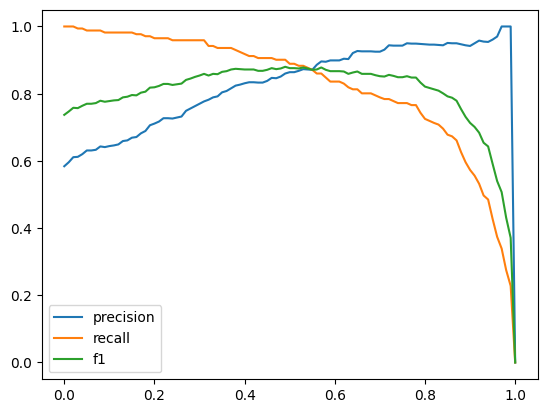

In [44]:
# plot precision and recall for different thresholds

plt.plot(metrics_df.threshold, metrics_df['precision'], label='precision')
plt.plot(metrics_df.threshold, metrics_df['recall'], label='recall')
plt.plot(metrics_df.threshold, metrics_df['f1'], label='f1')
plt.legend()

# Answer: 0.545

#### Question 4: F1 score

At which threshold F1 is maximal?
 - 0.14
 - 0.34
 - 0.54
 - 0.74

In [57]:
best_t = metrics_df.loc[metrics_df.f1.idxmax(), 'threshold']
best_t

# Answer: 0.54 (closest to 0.49 values

np.float64(0.49)

#### Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

How large is standard deviation of the scores across different folds?
 - 0.0001
 - 0.006
 - 0.06
 - 0.36

In [72]:
from sklearn.model_selection import KFold

def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val   = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val   = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

round(np.std(scores), 3)

# Answer: 0.06 (as the closest to 0.036 value)

np.float64(0.036)

#### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

Which C leads to the best mean score?
 - 0.000001
 - 0.001
 - 1

In [79]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

from tqdm.auto import tqdm

n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    scores = []

    kfold = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=1
    )

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val   = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val   = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

# Answer: C=0.001

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
